<a href="https://colab.research.google.com/github/gerald-liu/credit-card-default-prediction/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Default Prediction
Course Project of ISOM 3360, Spring 2020

Group 21

In [5]:
# Import basic libraries
import numpy as np 
import pandas as pd
import joblib # for saving models

In [6]:
# For Google Colab only
# from google.colab import files

In [7]:
# Load local data
data = pd.read_csv('data/data.csv',index_col = 'ID')

In [8]:
# Load data from GitHub
# data_url = 'https://raw.githubusercontent.com/gerald-liu/credit-card-default-prediction/master/data/data.csv?token=AIUUIXPDCVIHEXYNIDVP23K6UEHRA'
# data = pd.read_csv(data_url, index_col = 'ID')


## Variables
There are 25 variables:

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
- SEX: Gender (1=male, 2=female)
- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- MARRIAGE: Marital status (1=married, 2=single, 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment (1=yes, 0=no)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

## Data Cleaning
- No missing values, but there are a few anomalous things
- Variable name:
    1. PAY_0 is very confusing, should be changed to PAY_1 in consistensy with other variable names
    2. Change target variable name from 'default.pay.next.month' to 'def_pay'
- Understand categorical and numerical data respectively


In [10]:
# Change variable name
data = data.rename(columns={'default.payment.next.month': 'def_pay', 'PAY_0': 'PAY_1'})

In [11]:
# To have a general idea of the default probability
data['def_pay'].value_counts()[1] / data.shape[0]

0.2212

Conclusion: The dataset has a mild degree of imbalance, which is not considered as a significant problem.

In [12]:
# Categorical variables
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [13]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

EDUCATION has category 5 and 6 which are 'unknown', and label 0 which is undocumented. They can all be considered as missing values.

In [14]:
# Missing values are filled with random value according to probability of occurrence
mask_edu_good=data['EDUCATION'].isin(range(1,5))
data['EDUCATION'].mask(~mask_edu_good,data['EDUCATION'][mask_edu_good].sample(n=(~mask_edu_good).sum(),replace=True).tolist(),inplace=True)
data['EDUCATION'].value_counts()

2    14174
1    10723
3     4979
4      124
Name: EDUCATION, dtype: int64

In [15]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

MARRIAGE has a label 0 that is undocumented. It can be considered as missing value.

In [16]:
mask_marriage_good=data['MARRIAGE'].isin(range(1,4))
data['MARRIAGE'].mask(~mask_marriage_good,data['MARRIAGE'][mask_marriage_good].sample(n=(~mask_marriage_good).sum(),replace=True).tolist(),inplace=True)
data['MARRIAGE'].value_counts()

2    15990
1    13687
3      323
Name: MARRIAGE, dtype: int64

One might wonder what these labels might mean something.

"Other" in education can be education lower than the high school level.

"Other" in marriage could be, for example, "divorced". 


In [17]:
# Create lists for relevant numerical features
repayments = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_amounts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payments = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [18]:
# final check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [19]:
# export to csv
data.to_csv('data/data_clean.csv')

## Data visualization

In [390]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [391]:
# import libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Numerical features

#### Age

In [392]:
data['AGE'].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

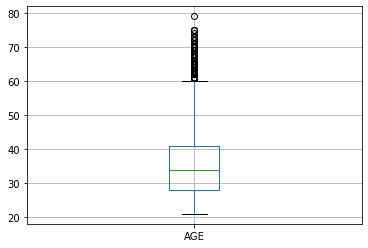

In [393]:
# boxplot for age
data.boxplot(column='AGE')

Conclusion: Outliers will not be removed because they are meaningful for this feature.

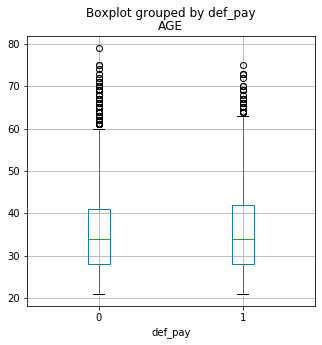

In [394]:
# boxplot for age regarding default
data.boxplot(column='AGE',by="def_pay",figsize=(5,5))

Conclusion: Age distribution is different for default clients and non-default clients, which implies that age is a significant feature.

#### Balance limit

In [395]:
data['LIMIT_BAL'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

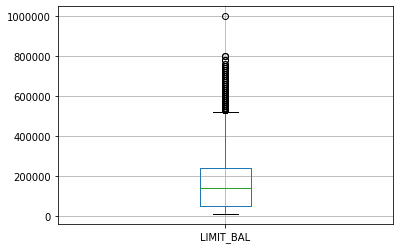

In [396]:
# boxplot for balance limit
data.boxplot(column='LIMIT_BAL')

Conclusion: There are a few outliers and we will apply normalization in certain models.

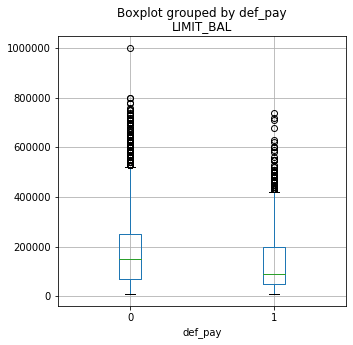

In [397]:
# boxplot for balance limit regarding default
data.boxplot(column='LIMIT_BAL',by="def_pay",figsize=(5,5))

Conclusion: Balance limit distribution is different for default clients and non-default clients, whicih implies that balance limit is a significent feature.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001895F893AC8>]],
      dtype=object)

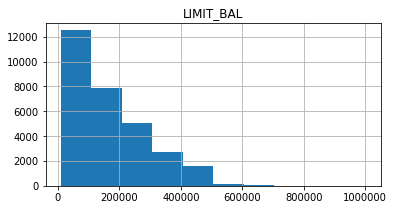

In [398]:
# histogram for balance limit
data.hist(column='LIMIT_BAL', figsize=(6, 3))

Conclusion: We will apply normalization in certain models.

#### Payment delay

In [399]:
data[repayments].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


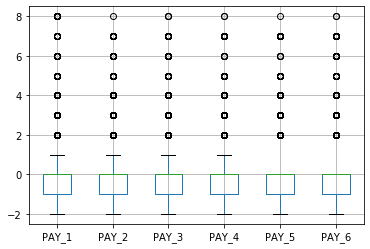

In [400]:
# boxplot for payment delay
data.boxplot(column=repayments)

Conclusion: Outliers will not be removed because they are meaningful for this feature.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001895FDBED48>,
      dtype=object)

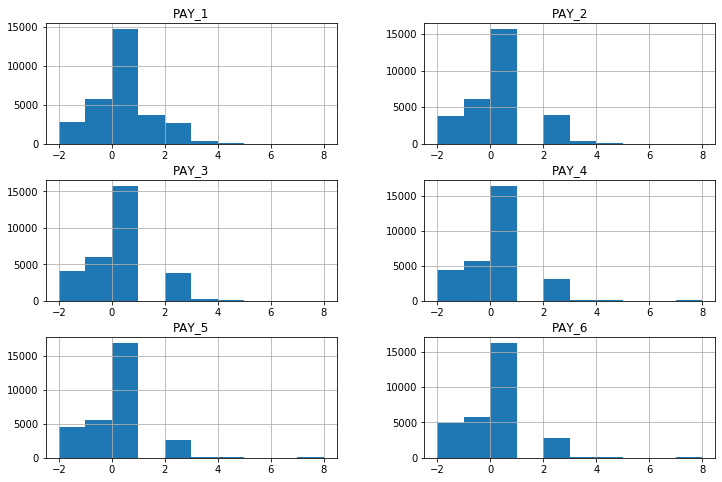

In [401]:
# histogram for payment delay
data.hist(column= repayments, figsize=(12, 8))

Conclusion: Normalization is not needed because the values are clean and standard.

#### Bill amounts

In [402]:
data[bill_amounts].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


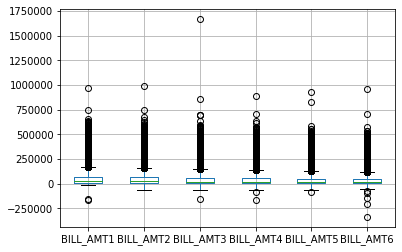

In [403]:
# boxplot for bill amounts
data.boxplot(column=bill_amounts)

Conclusion: There are a few outliers and we will apply normalization in certain models.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001896245B348>,
      dtype=object)

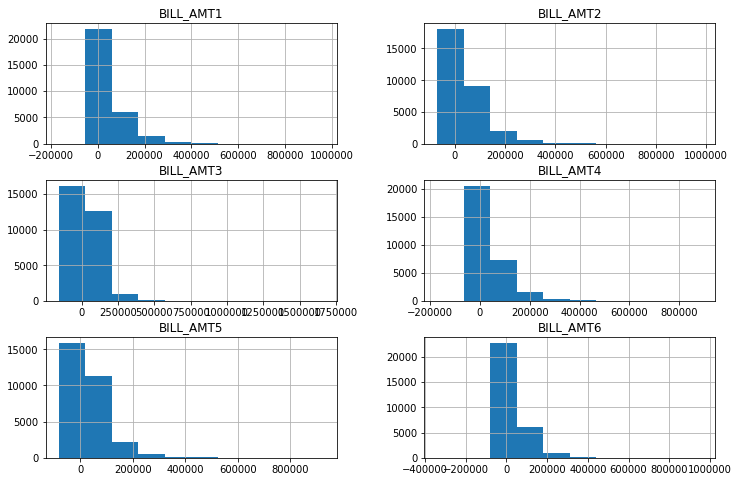

In [404]:
# histogram for bill amounts
data.hist(column= bill_amounts, figsize=(12, 8))

Conclusion: We will apply normalization in certain models.

#### Preivous payments

In [405]:
data[payments].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


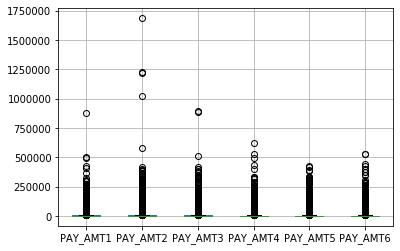

In [406]:
# boxplot for previous payments
data.boxplot(column=payments)

Conclusion: There are a few outliers and we will apply normalization in certain models.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000189638E6BC8>,
      dtype=object)

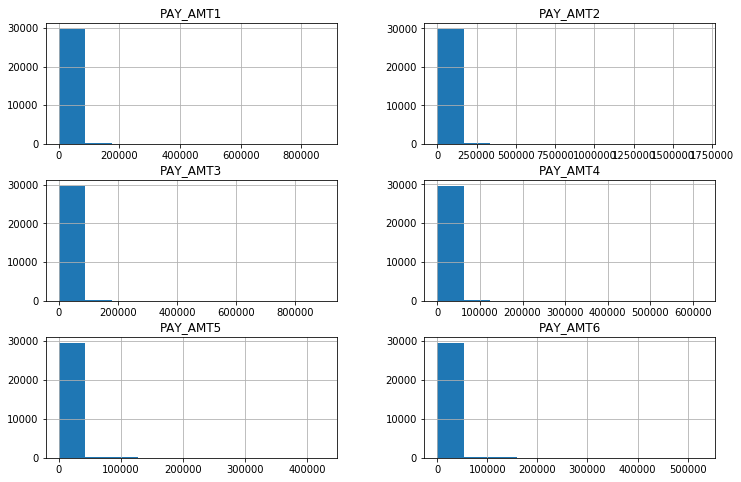

In [407]:
# histogram for preious payments
data.hist(column= payments, figsize=(12, 8))

Conclusion: We will apply normalization in certain models.

### Categorial features

In [408]:
# (old version)
# age_bins = pd.cut(data['AGE'], 10, retbins=True)
# age_bins = np.floor(age_bins).astype(int)
# df_male = data[data['SEX'] == 1]
# df_female = data[data['SEX'] == 2]

# prob_male = df_male.groupby(pd.cut(df_male['AGE'], bins=age_bins))['def_pay'].mean()
# prob_female = df_female.groupby(pd.cut(df_female['AGE'], bins=age_bins))['def_pay'].mean()

# plt.figure(figsize=(18, 6))
# plt.title('Default rate for different age groups')
# plt.bar(range(0, 30, 3), prob_male, width=1, label='Male')
# plt.bar(range(1, 31, 3), prob_female, width=1, label='Female')
# plt.xticks(range(0, 30, 3), prob_male.index)
# plt.legend(loc='upper left')
# plt.show()

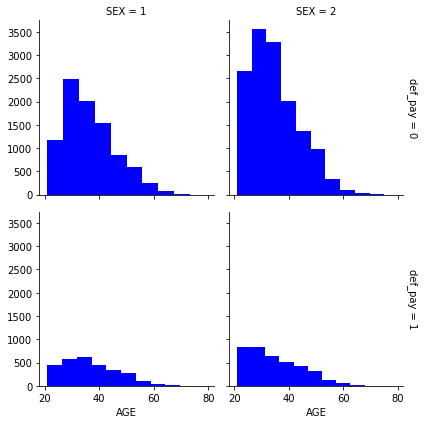

In [409]:
# Sex
# histogram for sex
g1 = sns.FacetGrid(data, col='SEX', row='def_pay', margin_titles=True)
g1.map(plt.hist,'AGE',color='blue')

Conclusion: Sex is a significant feature, and we can infer that male are more likely to default than female.

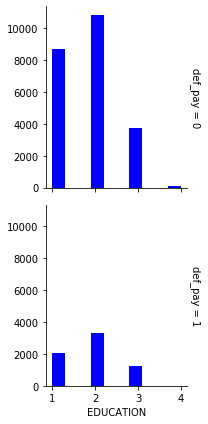

In [411]:
# Education
# histogram for education
g2 = sns.FacetGrid(data,row='def_pay', margin_titles=True)
g2.map(plt.hist,'EDUCATION',color='blue')

Conclusion: Education is a significant feature, and we can infer that people with higher education level are less likely to default.

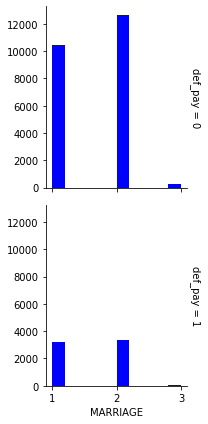

In [412]:
# MARRIAGE
# histogram for marriage
g3 = sns.FacetGrid(data,row='def_pay', margin_titles=True)
g3.map(plt.hist,'MARRIAGE',color='blue')

Conclusion: Marriage is a significant feature, and we can infer that married people are more likely to default than single people.

## Model Building

### Decision tree

In [413]:
# import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

#### With feature engineering

In [414]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

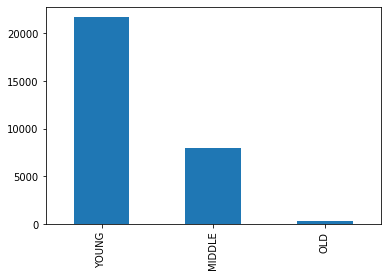

In [415]:
# binning of age
group_age=['YOUNG','MIDDLE','OLD']
data['AGE-BINNED']=pd.cut(data['AGE'],3,labels=group_age)
data['AGE-BINNED'].value_counts().plot(kind='bar')

In [416]:
# label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['AGE-BINNED'] = le.fit_transform(data['AGE-BINNED'])

We will use min-max scaling for numerical features. As there are meaningful negative values, log scaling should not be used. The distribution is not normal, so z-score should not be used. Feature clipping will clip a few values which we believe are in fact normal points. Thus, we choose min-max scaling.

In [417]:
# normalization of certain numerical features
numerical_features_featureengineering = ['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                                         'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(data[numerical_features_featureengineering])
data[numerical_features_featureengineering] = scaler.transform(data[numerical_features_featureengineering])

In [418]:
# (log scaling)

# numerical_features_featureengineering = ['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
#                                          'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
# data[numerical_features_featureengineering]=data[numerical_features_featureengineering].transform(lambda x:np.log(x+1))

# from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p, validate=True)
# data[numerical_features_featureengineering]=transformer.transform(data[numerical_features_featureengineering])

In [419]:
# data.isnull().any()

In [422]:
data.to_csv('data/data_decisiontree.csv')

In [423]:
data = pd.read_csv('data/data_decisiontree.csv',index_col = 'ID')

In [424]:
features=['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE-BINNED'] + repayments + bill_amounts + payments
target=['def_pay']

In [425]:
X1=data[features]
y1=data[target]

In [426]:
DTM1_0 = DecisionTreeClassifier()
DTM1_0.fit(X1,y1)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [427]:
DTM1_0.get_depth()

44

In [428]:
DTM1_0.get_n_leaves()

4850

In [429]:
# import cross validation
from sklearn.model_selection import cross_val_score, GridSearchCV

In [430]:
score_cv_dt = cross_val_score(DTM1_0, X1, y1, cv=10)

In [431]:
score_cv_dt.mean()

0.7262666666666667

In [432]:
# define the numbers to try out for depth and max number of leaf nodes 
depths = list(range(5, 45, 5))
num_leafs = list(range(500, 5000, 500))

In [433]:
param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

In [434]:
# define the model using GridSearchCV
DTM1 = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=10)

In [435]:
DTM1.fit(X1,y1)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
     

In [436]:
# find the best parameters
DTM1.best_params_

{'max_depth': 5, 'max_leaf_nodes': 4000}

In [437]:
DTM1.best_score_

0.8197333333333334

In [438]:
DTM1_best = DTM1.best_estimator_

In [439]:
joblib.dump(DTM1_best, 'models/DTM1_best.joblib')

['models/DTM1_best.joblib']

In [440]:
# For Google Colab only
# files.download('models/DTM1_best.joblib') 

In [441]:
# For Google Colab only
# DTM1_file = files.upload()

In [442]:
DTM1_best = joblib.load('models/DTM1_best.joblib')

#### Without feature engineering

In [443]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [444]:
# define independent variables / attirbutes / features
features = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE'] + repayments + bill_amounts + payments
# define one single target variable / label
target = ['def_pay']

In [445]:
# get defined training dataset
X2 = data[features]
y2 = data[target]

In [446]:
# build a decision tree model with the defalut hyperparameter settings
DTM2_0 = DecisionTreeClassifier()
DTM2_0.fit(X2,y2)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [447]:
DTM2_0.get_depth()

43

In [448]:
DTM2_0.get_n_leaves()

4752

In [449]:
# import cross validation
from sklearn.model_selection import cross_val_score, GridSearchCV

In [450]:
# CV
score_cv_dt = cross_val_score(DTM2_0, X2, y2, cv=10)

In [451]:
score_cv_dt.mean()

0.7273333333333334

In [452]:
# define the numbers to try out for depth and max number of leaf nodes 
depths = list(range(5, 45, 5))
num_leafs = list(range(500, 5000, 500))

In [453]:
param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

In [454]:
# define the model using GridSearchCV
DTM2 = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=10)

In [455]:
DTM2.fit(X2,y2)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
     

In [456]:
# find the best parameters
DTM2.best_params_

{'max_depth': 5, 'max_leaf_nodes': 2500}

In [457]:
DTM2.best_score_

0.8196

In [458]:
DTM2_best = DTM2.best_estimator_

In [459]:
joblib.dump(DTM2_best, 'models/DTM2_best.joblib')

['models/DTM2_best.joblib']

In [460]:
# For Google Colab only
# files.download('models/DTM2_best.joblib') 

In [461]:
# For Google Colab only
# DTM2_file = files.upload()

In [462]:
DTM2_best = joblib.load('models/DTM2_best.joblib')

### Logistic regression

#### Feature engineering method 1

If we do not conduct scaling on numerical features, logistic regression will give a convergence warning. So we choose to do mix-max scaling for numerical features and need to do one-hot encoding for categorical features. Also, we apply binning for the feature age.

In [463]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [464]:
# binning of age
group_age=['YOUNG','MIDDLE','OLD']
data['AGE-BINNED']=pd.cut(data['AGE'],3,labels=group_age)
data=data.drop(columns='AGE')

In [465]:
# the categorical features to carry out feature engineering
categorical_features = ['AGE-BINNED','SEX', 'EDUCATION', 'MARRIAGE']
# one-hot encoding
data = pd.get_dummies(data, columns=categorical_features,drop_first = True)

In [466]:
# the numerical features to carry out feature engineering
numerical_features_featureengineering = ['LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
                                         'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                                         'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(data[numerical_features_featureengineering])
data[numerical_features_featureengineering] = scaler.transform(data[numerical_features_featureengineering])

In [467]:
# Export preprocessed data
data.to_csv('data/data_logistic1.csv')

In [468]:
# For Google Colab only
# files.download('data/data_logistic1.csv') 

In [469]:
# Read preprocessed data from local drive
data = pd.read_csv('data/data_logistic1.csv',index_col = 'ID')

In [470]:
# Read preprocessed data from GitHub
# data_logistc1_url = 'https://raw.githubusercontent.com/gerald-liu/credit-card-default-prediction/master/data/data_clean.csv?token=AIUUIXPDCVIHEXYNIDVP23K6UEHRA'
# data = pd.read_csv(data_logistic1_url, index_col = 'ID')

In [471]:
X3 = data.drop(columns='def_pay')
y3=data['def_pay']

In [472]:
# import Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression

In [473]:
lr1 = LogisticRegression(penalty='l1', solver='saga',max_iter=1000)

In [474]:
lr1

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [475]:
# change target column to array
y3_act = y3.values.ravel()

In [476]:
score_cv_lr = cross_val_score(lr1, X3, y3_act, cv=10)

In [477]:
score_cv_lr.mean()

0.8095666666666667

In [478]:
joblib.dump(lr1, 'models/Logistic1.joblib')

['models/Logistic1.joblib']

In [479]:
# For Google Colab only
# files.download('models/Logistic1.joblib') 

In [480]:
# For Google Colab only
# lr_file = files.upload()

In [481]:
lr1 = joblib.load('models/Logistic1.joblib')

#### Feature engineering method 2

If we do not conduct scaling on numerical features, logistic regression will give a convergence warning. So we choose to do mix-max scaling for numerical features and need to do one-hot encoding for categorical features.

In [482]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [483]:
# the categorical features to carry out feature engineering
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
# one-hot encoding
data = pd.get_dummies(data, columns=categorical_features,drop_first = True)

In [484]:
# the numerical features to carry out feature engineering
numerical_features_featureengineering = ['AGE','LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6',
                                         'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
                                         'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(data[numerical_features_featureengineering])
data[numerical_features_featureengineering] = scaler.transform(data[numerical_features_featureengineering])

In [485]:
# Export preprocessed data
data.to_csv('data/data_logistic2.csv')

In [486]:
# For Google Colab only
# files.download('data/data_logistic2.csv') 

In [487]:
# Read preprocessed data from local drive
data = pd.read_csv('data/data_logistic2.csv',index_col = 'ID')

In [488]:
# Read preprocessed data from GitHub
# data_logistc1_url = 'https://raw.githubusercontent.com/gerald-liu/credit-card-default-prediction/master/data/data_clean.csv?token=AIUUIXPDCVIHEXYNIDVP23K6UEHRA'
# data = pd.read_csv(data_logistic1_url, index_col = 'ID')

In [489]:
X4= data.drop(columns='def_pay')
y4=data['def_pay']

In [490]:
# import Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression

In [491]:
lr2 = LogisticRegression(penalty='l1', solver='saga',max_iter=1000)

In [492]:
lr2

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [493]:
# change target column to array
y4_act = y4.values.ravel()

In [494]:
score_cv_lr = cross_val_score(lr2, X4, y4_act, cv=10)

In [495]:
score_cv_lr.mean()

0.8097333333333333

In [496]:
joblib.dump(lr2, 'models/Logistic2.joblib')

['models/Logistic2.joblib']

In [497]:
# For Google Colab only
# files.download('models/Logistic2.joblib') 

In [498]:
# For Google Colab only
# lr_file = files.upload()

In [499]:
lr2 = joblib.load('models/Logistic2.joblib')

### K-means clustering

In [522]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [523]:
# the categorical features to carry out feature engineering
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

# the numerical features to carry out feature engineering
numerical_features_featureengineering = ['AGE','LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

In [524]:
# one-hot encoding
data = pd.get_dummies(data, columns=categorical_features,drop_first = True)

In [525]:
# Normalize attributes
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(data[numerical_features_featureengineering])
data[numerical_features_featureengineering] = scaler.transform(data[numerical_features_featureengineering])

In [526]:
# Export preprocessed data
data.to_csv('data/data_kmeans.csv')

In [527]:
# Read preprocessed data from local drive
data = pd.read_csv('data/data_kmeans.csv',index_col = 'ID')

In [528]:
X = data.drop(columns='def_pay')
y = data['def_pay']

In [529]:
# import KMeans from sklearn
from sklearn.cluster import KMeans

In [530]:
# set number of clusters
kmeansmodel = KMeans(n_clusters=2)

In [531]:
# fit data
kmeansmodel.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [532]:
# centroids
centroids = kmeansmodel.cluster_centers_
centroids

array([[ 1.77374253e-01,  2.61100241e-01,  1.87937571e-01,
         1.72962214e-01,  1.70529508e-01,  1.65885252e-01,
         1.62466827e-01,  1.60457475e-01,  1.89744675e-01,
         1.10842665e-01,  1.11238780e-01,  1.99479763e-01,
         1.19359978e-01,  2.89740000e-01,  7.08493233e-03,
         3.93614810e-03,  6.45567493e-03,  8.40783130e-03,
         1.19825619e-02,  1.06636891e-02,  5.91810944e-01,
        -1.55986335e-13,  3.14608871e-01,  7.83520789e-03,
         5.62808037e-01,  1.00467585e-02],
       [ 1.38643098e-01,  2.37076872e-01,  2.09933681e-01,
         2.01876676e-01,  1.97728235e-01,  1.91385636e-01,
         1.85565119e-01,  1.82538451e-01,  1.94192037e-01,
         1.15181939e-01,  1.13181852e-01,  2.02466471e-01,
         1.22025888e-01,  2.92091410e-01,  5.81174238e-03,
         3.04601450e-03,  5.13557869e-03,  7.06091942e-03,
         1.04367035e-02,  8.97407315e-03,  6.17045294e-01,
         1.00000000e+00,  8.24340596e-15, -7.23379689e-16,
         4.99

In [533]:
# centroids
interation = kmeansmodel.n_iter_
interation

2

In [534]:
# SSD
SSD = kmeansmodel.inertia_
SSD

22833.89973806181

In [535]:
# centroids
distance = kmeansmodel.transform(X)
distance

array([[1.34927019, 0.78611079],
       [1.27264173, 0.72695343],
       [1.21522949, 0.63673873],
       ...,
       [1.41683259, 0.97154504],
       [1.09790264, 1.64262994],
       [1.34918112, 0.82419164]])

In [536]:
# Get Labels of each point 
data_label = kmeansmodel.labels_

In [537]:
# Create comparison table between actual def_pay and predict cluster
data_comparison=pd.DataFrame(data_label,y,columns=['cluster'])
data_comparison

,cluster
def_pay,
1,1
1,1
0,1
0,1
0,1
...,...
0,0
0,0
1,1


In [542]:
# Find corresponding instances that belong to each def_pay type
data_nondefault = data_comparison.loc[0]
data_default = data_comparison.loc[1]

In [543]:
# Count value for different cluster regarding one type of def_pay
data_nondefault[data_nondefault.columns[0]].value_counts()

0    12528
1    10836
Name: cluster, dtype: int64

In [544]:
data_default[data_default.columns[0]].value_counts()

1    3338
0    3298
Name: cluster, dtype: int64

Based on majority rule, cluster 0 is default, cluster 1 is nondefault.

In [545]:
# the results above can be regarded as a "confusion matrix"
kmeans_TN=data_nondefault.loc[data_nondefault.cluster == 1, 'cluster'].count()
kmeans_TP=data_default.loc[data_default.cluster == 0, 'cluster'].count()
kmeans_FN=data_default.loc[data_default.cluster == 1, 'cluster'].count()
kmeans_FP=data_nondefault.loc[data_nondefault.cluster == 0, 'cluster'].count()

In [546]:
kmeans_accuracy=(kmeans_TN+kmeans_TP)/(kmeans_TN+kmeans_TP+kmeans_FN+kmeans_FP)
kmeans_accuracy

0.47113333333333335

## Model Evaluation

In [547]:
# import evaluation tools
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
import matplotlib as mpl
import matplotlib.pyplot as plt

### Decision tree

#### With feature engineering

In [548]:
DTM1_pred = DTM1_best.predict(X1)

In [549]:
# Confusion matrix
print("Confusion Matrix:", '\n',confusion_matrix(y1, DTM1_pred))
print("Accuracy:",accuracy_score(y1, DTM1_pred, normalize=True, sample_weight=None))

Confusion Matrix: 
 [[22296  1068]
 [ 4211  2425]]
Accuracy: 0.8240333333333333


In [550]:
print(classification_report(y1, DTM1_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     23364
           1       0.69      0.37      0.48      6636

    accuracy                           0.82     30000
   macro avg       0.77      0.66      0.69     30000
weighted avg       0.81      0.82      0.80     30000



In [551]:
DTM1_proba = DTM1_best.predict_proba(X1)
DTM1_proba = DTM1_proba[:,0]
DTM1_proba

array([0.51351351, 0.56028369, 0.90893551, ..., 0.37442922, 0.90893551,
       0.84174528])

In [552]:
fpr, tpr, thresholds = roc_curve(y1,DTM1_proba,pos_label=0)

In [553]:
auc(fpr, tpr)

0.7633369696030606

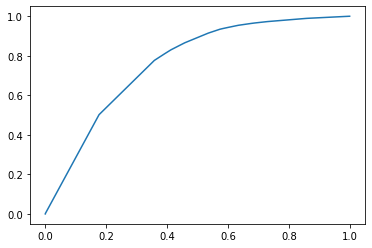

In [554]:
plt.plot(fpr,tpr)

#### Without feature engineering

In [555]:
DTM2_pred = DTM2_best.predict(X2)

In [556]:
# Confusion matrix
print("Confusion Matrix:", '\n',confusion_matrix(y2, DTM2_pred))
print("Accuracy:",accuracy_score(y2, DTM2_pred, normalize=True, sample_weight=None))

Confusion Matrix: 
 [[22343  1021]
 [ 4256  2380]]
Accuracy: 0.8241


In [557]:
print(classification_report(y2,DTM2_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89     23364
           1       0.70      0.36      0.47      6636

    accuracy                           0.82     30000
   macro avg       0.77      0.66      0.68     30000
weighted avg       0.81      0.82      0.80     30000



In [558]:
DTM2_proba = DTM2_best.predict_proba(X2)
DTM2_proba = DTM2_proba[:,0]
DTM2_proba

array([0.51351351, 0.56028369, 0.90893551, ..., 0.31451613, 0.90893551,
       0.84174528])

In [559]:
fpr, tpr, thresholds = roc_curve(y2,DTM2_proba,pos_label=0)

In [560]:
auc(fpr, tpr)

0.763139312176536

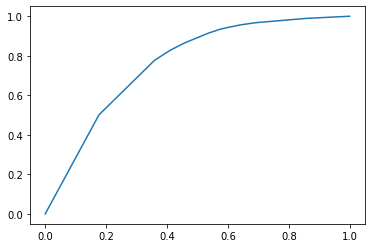

In [561]:
plt.plot(fpr,tpr)

### Logistic regression

In [562]:
from sklearn.model_selection import cross_val_predict

#### Feature engineering method 1

In [563]:
# predict value of target based on cross validation
lr1_pred = cross_val_predict(lr1, X3, y3_act, cv=10)

In [564]:
# Confusion matrix
print("Confusion Matrix:", '\n',confusion_matrix(y3_act, lr1_pred))
print("Accuracy:",accuracy_score(y3_act, lr1_pred, normalize=True, sample_weight=None))

Confusion Matrix: 
 [[22732   632]
 [ 5081  1555]]
Accuracy: 0.8095666666666667


In [565]:
print(classification_report(y3_act, lr1_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     23364
           1       0.71      0.23      0.35      6636

    accuracy                           0.81     30000
   macro avg       0.76      0.60      0.62     30000
weighted avg       0.79      0.81      0.77     30000



In [566]:
lr1_proba = cross_val_predict(lr1, X3, y3_act, cv=10, method='predict_proba')
lr1_proba = lr1_proba[:,0]
lr1_proba

array([0.47082496, 0.84446827, 0.80279774, ..., 0.1826041 , 0.79559686,
       0.73246574])

In [567]:
fpr, tpr, thresholds = roc_curve(y3_act,lr1_proba,pos_label=0)

In [568]:
auc(fpr, tpr)

0.7200797880574217

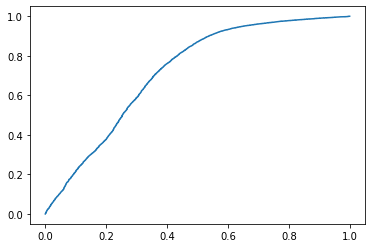

In [569]:
plt.plot(fpr,tpr)

#### Feature engineering method 2

In [570]:
# predict value of target based on cross validation
lr2_pred = cross_val_predict(lr2, X4, y4_act, cv=10)

In [571]:
# Confusion matrix
print("Confusion Matrix:", '\n',confusion_matrix(y4_act, lr2_pred))
print("Accuracy:",accuracy_score(y4_act, lr2_pred, normalize=True, sample_weight=None))

Confusion Matrix: 
 [[22737   627]
 [ 5081  1555]]
Accuracy: 0.8097333333333333


In [572]:
print(classification_report(y4_act, lr2_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     23364
           1       0.71      0.23      0.35      6636

    accuracy                           0.81     30000
   macro avg       0.76      0.60      0.62     30000
weighted avg       0.79      0.81      0.77     30000



In [573]:
lr2_proba = cross_val_predict(lr2, X4, y4_act, cv=10, method='predict_proba')
lr2_proba = lr2_proba[:,0]
lr2_proba

array([0.47915586, 0.84606306, 0.79758454, ..., 0.17627483, 0.80286024,
       0.73702342])

In [574]:
fpr, tpr, thresholds = roc_curve(y4_act,lr2_proba,pos_label=0)

In [575]:
auc(fpr, tpr)

0.7200204595479214

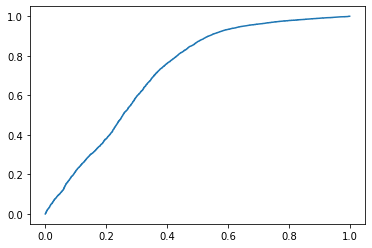

In [576]:
plt.plot(fpr,tpr)

### K-means clustering

In this case, the cardinality is fixed due to that the number of clusters is fixed, so the way of checking if cardinality correlates with magnitude cannot be used. Thus, the only way is to interpret the above results, which kind of serve as a "confusion matrix". As shown in the model building part, the accuracy is around 0.5, which is similar to random guess.